# GNN Modelle

Dieses Notebook stellt verschiedene Modell, welche zum trainieren porbiert wurden dar. Das Training der Modelle wird hier nicht durchgeführt, sondern ist ausgelaget in dem Python Script. train_gcn.py

-> Final verwendet wird das Model gcn3_neu. Dieses verwendet ConvLayer, welche von DIG angepasst wurden für die Anwendung mit den XAI-Techniken


## Packages Installieren

In [ ]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric==1.7.2

In [ ]:
%%capture
!pip install pm4py

In [ ]:
%%capture
!pip install dive-into-graphs

In [ ]:
from pathlib import Path
# Hauptordner-Pfad
path = Path("/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM")
%cd "/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM"

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
from torch_geometric.data import DataLoader
from dig.xgraph.dataset import BA_LRP

# Module für das Preprocessing der verwendeten Datensätze
from preprocessing.loanApplication import *
from preprocessing.reviewSynthetic import *
from dig.xgraph.dataset import BA_LRP
from models.gcn2 import *
from models.gcn3 import *
import joblib

# Verwendete Laufzeit-Umgebung definieren (GPU oder CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Baseline Datensatz

Es wurde GCN Modelle auf die drei verwendeten Datensätze trainiert. Hier werden die vortrainierten Datens#tze geladen.

Verwendeter Datensatz: **Review Dataset**

In [ ]:
# dataset_name = "baseline_ba_lrp"
# dataset = BA_LRP('datasets')   #.shuffle()

### laden des Datensatzes

In [ ]:
# Laden eines bereits vorverarbeiteten Datensazes
dataset_name = "loan_sn_f2_ohe_wEvents_4"
dataset = torch.load(path / str("datasets/dataset_"+ dataset_name))
feature  = joblib.load("datasets/encoder_" + dataset_name + ".joblib")

In [ ]:
#dataset.shuffle()     # Mischen

In [ ]:
#feature

In [ ]:
data = dataset[4]

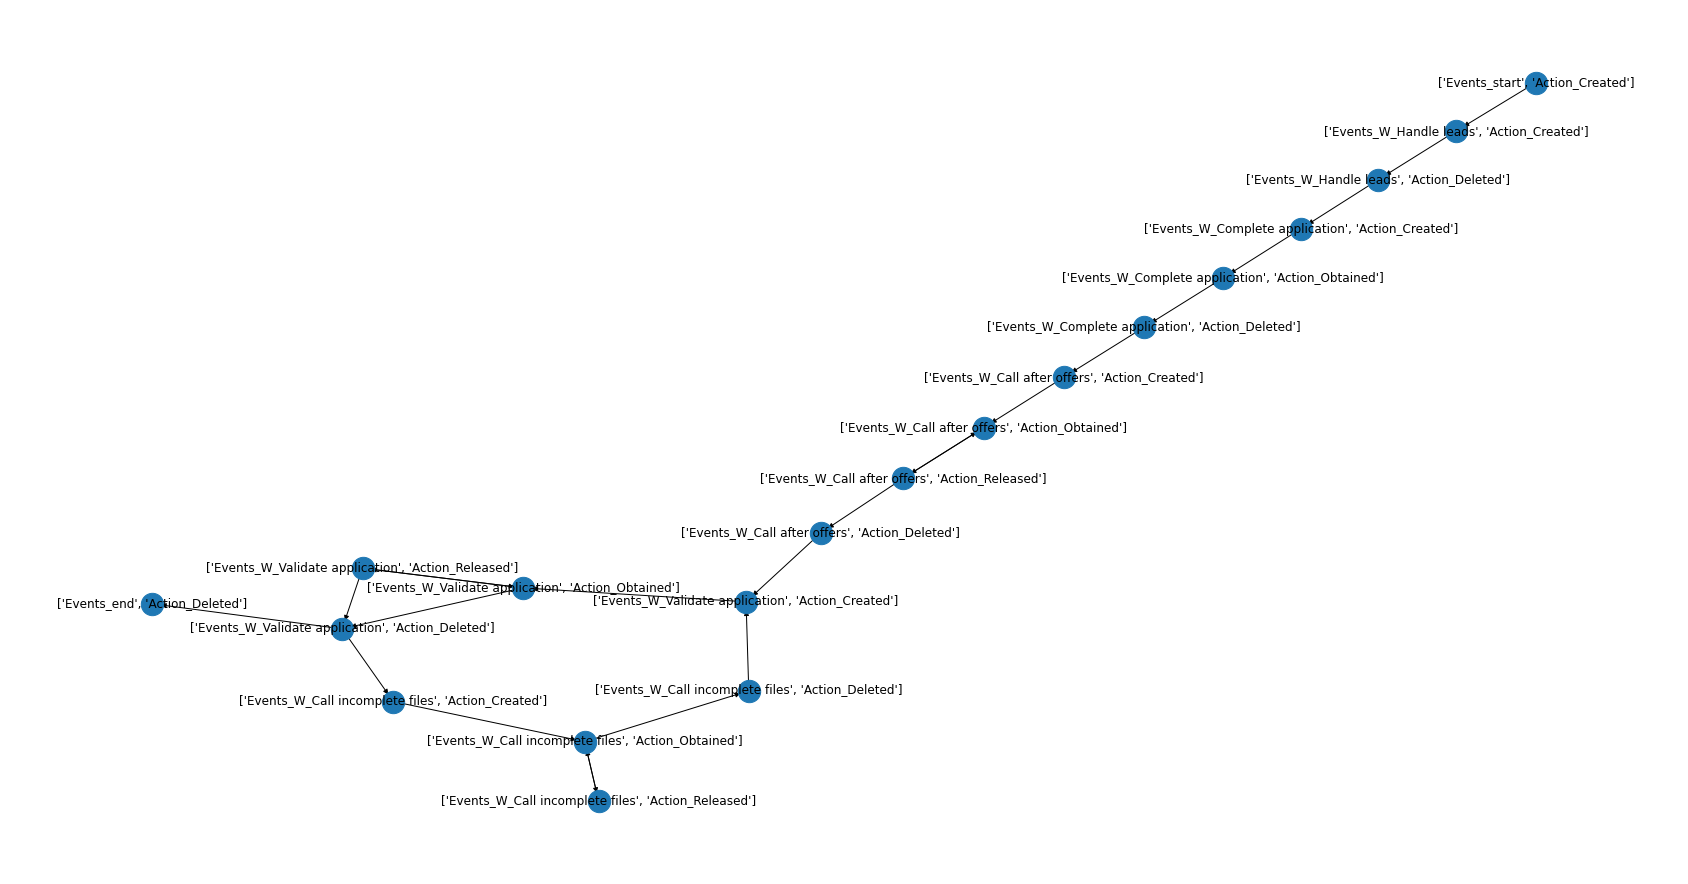

In [ ]:
from utilities_preprocessing import  GraphDatasetHelper
# # Namen können nur bei label encoder angezeigt werden
helper = GraphDatasetHelper(node_feature = feature)
helper.visualise_dataset(data)

### Dataset teilen in Test- und Traindataset

In [ ]:
# Split Datasets in Train, Test und XAI_Validation Dataset

split = int(0.8*len(dataset))
#dataset = dataset.shuffle()
#xai_set = dataset[:1]
ds_train = dataset[:split]
ds_test = dataset[split:]

## Dataloader erstellen

In [ ]:
ds_train[0]

Data(edge_index=[2, 13], x=[12, 15], y=[1])

In [ ]:
# size = len(dataset)
# split = int(0.8*len(dataset))
# #dataset = dataset.shuffle()
# xai_set = dataset[:1]
# ds_train = dataset[1:split]
# ds_test = dataset[split:]

In [ ]:
batch_size= 100 # 64 
train_loader = DataLoader(ds_train, batch_size=batch_size)
test_loader = DataLoader(ds_test, batch_size=batch_size)
# xai_loader =DataLoader(xai_set, batch_size = 1)

## Modell trainieren

Verwendetes Model: **GCN**

Grundlage für Model:
https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing


Das Training eines GNN für die Graphenklassifizierung folgt normalerweise einem einfachen Rezept: 

    - Einbettung jedes Knotens durch mehrere Runden der Nachrichtenübermittlung (Message Passing)
    - Aggregieren der Knoteneinbettungen in eine einheitliche Grapheneinbettung (Ausleseschicht)
    - Trainieren eines endgültigen Klassifikators auf der Grapheneinbettung

###GCN1

In [ ]:
#%%writefile models/gcn.py
from torch.nn import Linear, ModuleList
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric.nn as gnn 
from torch_geometric.nn import global_mean_pool
from torch_geometric.data.batch import Batch
from torch import Tensor
import torch


class GCN1(torch.nn.Module):
    def __init__(self, hidden_channels, input_dim):
        super(GCN1, self).__init__()
        
        torch.manual_seed(12345)
        self.conv1 = GCNConv(input_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

        

  

    def forward(self, *args, **kwargs): #x, edge_index, batch

        # Input Werte auslesen
        x, edge_index, batch = self.get_data(*args, **kwargs)
  
        # 1. Knoten Embedding erhalten
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        #print("x: ", x)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        #print("pooling: ",x )
        # 3. Finaler Klassifier
        x = F.dropout(x, p=0.5)
        x = self.lin(x)
        #print("classifier: ", x)
        
        return x

    def get_data(self, *args, **kwargs):
      '''
      von https://github.com/divelab/DIG/blob/dig/dig/xgraph/models/models.py
      Ermöglicht dem Model verschiedene Input Parameter zu verarbeiten
      '''
      data: Batch = kwargs.get("data") or None

      if not data:
          if not args:             # Werte direkt x, edge-index und batch zugewiesen
              assert 'x' in kwargs
              assert 'edge_index' in kwargs
              x, edge_index = kwargs['x'], kwargs['edge_index'],
              batch = kwargs.get('batch')
              if batch is None:
                  batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
          elif len(args) == 2:      # Nur x und edge_index als Input übergeben. Batch wird manuel berechnet
              x, edge_index = args[0], args[1]
              batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
          elif len(args) == 3:      # x, edge_index und bath als Input übergeben
              x, edge_index, batch = args[0], args[1], args[2]
          else:
              raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
      else:                         # Data-Objekt als Input übergeben
          x, edge_index, batch = data.x, data.edge_index, data.batch

      return x, edge_index, batch

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
      '''
      Auslesen der Node Embeddings
      '''
      x, edge_index, batch = self.get_data(*args, **kwargs)
      
      # 1. Node Embeddings erhalten
      x = self.conv1(x, edge_index)
      x = x.relu()
      x = self.conv2(x, edge_index)
      x = x.relu()
      x = self.conv3(x, edge_index)
          
      return x

# model = GCN(hidden_channels=64)
# print(model)


In [ ]:
t = next(iter(dataset))
t.edge_index.size()



torch.Size([2, 13])

### GCN 3

Nutzt als ConvLayer die etwas angepasste Implementierung von der DIG-Libary. Wurde getestet um LPD-Modell zu nutzen.


https://github.com/divelab/DIG/blob/dig/dig/xgraph/models/models.py

In [ ]:
%%writefile models/gcn3_neu.py

from torch_sparse import SparseTensor
from torch.nn import Linear, ModuleList
import torch.nn as nn
import torch.nn.functional as F
#from torch_geometric.nn import GCNConv
from dig.xgraph.models import GCNConv

import torch_geometric.nn as gnn 
from torch_geometric.nn import global_mean_pool
from torch_geometric.data.batch import Batch
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch import Tensor
import torch

## Eigene GCNConv Klasse, da diese für GNN-LRP angepasst werden musste
class GCNConv_n(gnn.GCNConv):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_weight = None

    def forward(self, x: Tensor, edge_index: Adj, edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize and edge_weight is None:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        # --- add require_grad ---
        edge_weight.requires_grad_(True)

        x = torch.matmul(x, self.weight)


        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        return out



class GCN3(torch.nn.Module):
    def __init__(self, hidden_channels, input_dim, num_layer):
        super().__init__()    #GCN, self
        dim_node = input_dim
        dim_hidden = hidden_channels
        num_layer = num_layer
        self.conv1 = GCNConv(dim_node, dim_hidden)
        self.convs = ModuleList(
            [
                GCNConv(dim_hidden, dim_hidden)
                for _ in range(num_layer - 1)
             ]
        )
        self.relu1 = nn.ReLU()
        self.relus = nn.ModuleList(
            [
                nn.ReLU()
                for _ in range(num_layer - 1)
            ]
        )
        self.lin = Linear(dim_hidden, 2)

        self.readout = GlobalMeanPool()

        self.ffn = nn.Sequential(*(
                [nn.Linear(dim_hidden, dim_hidden)] +
                [nn.ReLU(), nn.Dropout(), nn.Linear(dim_hidden, 2)]
        ))

        self.dropout = nn.Dropout()

        #self.emb = 0

    # def setbatch(self, batch):
    #     self.batch = batch

    def forward(self, *args, **kwargs): #x, edge_index, batch

        # Input Werte auslesen
        x, edge_index, batch = self.get_data(*args, **kwargs)
  
        # 1. Obtain node embeddings 
        
        # x = self.conv1(x, edge_index)
        # x = x.relu()
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.conv3(x, edge_index)
      
        post_conv = self.relu1(self.conv1(x, edge_index))
        for conv, relu in zip(self.convs, self.relus):
            post_conv = relu(conv(post_conv, edge_index))

        x = post_conv
          
        
        #self.emb = x
        # 2. Readout layer
        #x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        # x = F.dropout(x, p=0.5, training = self.training)
        # x = self.lin(x)

        out_readout = self.readout(post_conv, batch)

        out = self.ffn(out_readout)       
        
        return out

    def get_data(self, *args, **kwargs):
      '''
      von https://github.com/divelab/DIG/blob/dig/dig/xgraph/models/models.py
      Ermöglicht dem Model verschiedene Input Parameter zu verarbeiten
      '''
      data: Batch = kwargs.get("data") or None

      if not data:
          if not args:             # Werte direkt x, edge-index und batch zugewiesen
              assert 'x' in kwargs
              assert 'edge_index' in kwargs
              x, edge_index = kwargs['x'], kwargs['edge_index'],
              batch = kwargs.get('batch')
              if batch is None:
                  batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
          elif len(args) == 2:      # Nur x und edge_index als Input übergeben. Batch wird manuel berechnet
              x, edge_index = args[0], args[1]
              batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
          elif len(args) == 3:      # x, edge_index und bath als Input übergeben
              x, edge_index, batch = args[0], args[1], args[2]
          else:
              raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
      else:                         # Data-Objekt als Input übergeben
          x, edge_index, batch = data.x, data.edge_index, data.batch

      return x, edge_index, batch

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
      '''
      Auslesen der Node Embeddings
      '''
      x, edge_index, batch = self.get_data(*args, **kwargs)
      
      # 1. Node Embeddings erhalten
      post_conv = self.relu1(self.conv1(x, edge_index))
      for conv, relu in zip(self.convs, self.relus):
          post_conv = relu(conv(post_conv, edge_index))
          
      return post_conv

class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

class GlobalMeanPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return gnn.global_mean_pool(x, batch)

Writing models/gcn3_neu.py


###GCN2

Speichert GCNConv Layer in einer ModuleList. Auf diese wird in manchen Explainern zugegriffen (GradCam). Ansonsten ist dieses Modell gleich wie GCN1. Es Beinhaltet für das Node-Embedding drei Conv-Layer, ein Global Mean Pool Layer und einen linearen Klassifier.


https://github.com/divelab/DIG/blob/dig/dig/xgraph/models/models.py

In [ ]:
%%writefile models/gcn2.py
from torch.nn import Linear, ModuleList
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric.nn as gnn 
from torch_geometric.nn import global_mean_pool
from torch_geometric.data.batch import Batch
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch import Tensor
import torch
class GCN2(torch.nn.Module):
    def __init__(self, hidden_channels, input_dim):
        super(GCN2,self).__init__()    #GCN, self
        dim_node = input_dim
        dim_hidden = hidden_channels
        num_layer = 3
        self.conv1 = GCNConv(dim_node, dim_hidden)
        self.convs = ModuleList(
            [
                GCNConv(dim_hidden, dim_hidden)
                for _ in range(num_layer - 1)
             ]
        )
        self.relu1 = nn.ReLU()
        self.relus = nn.ModuleList(
            [
                nn.ReLU()
                for _ in range(num_layer - 1)
            ]
        )

        #self.readout = GlobalMeanPool()  # verändert
        self.lin = Linear(dim_hidden, 2)

        #self.dropout = nn.Dropout()

        #self.emb = 0

    # def setbatch(self, batch):
    #     self.batch = batch

    def forward(self, *args, **kwargs): #x, edge_index, batch

        # Input Werte auslesen
        x, edge_index, batch = self.get_data(*args, **kwargs)
  
        # 1. Obtain node embeddings 
        
        # x = self.conv1(x, edge_index)
        # x = x.relu()
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.conv3(x, edge_index)
      
        post_conv = self.relu1(self.conv1(x, edge_index))
        #print("First Conv: ", post_conv.size())
        for conv, relu in zip(self.convs, self.relus):
            post_conv = relu(conv(post_conv, edge_index))

        x = post_conv
          
        
        #self.emb = x
        # 2. Readout layer
        #print("H: ", x.size())
        x = global_mean_pool(x, batch)
        #x = self.readout(x, batch)  # [batch_size, hidden_channels]
        #print("Readout: ", x.size())

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training = self.training)
        #print("Dropout: ", x.size())
        x = self.lin(x)
        #print("Lin: ", x.size())
        
        
        return x

    def get_data(self, *args, **kwargs):
      '''
      von https://github.com/divelab/DIG/blob/dig/dig/xgraph/models/models.py
      Ermöglicht dem Model verschiedene Input Parameter zu verarbeiten
      '''
      data: Batch = kwargs.get("data") or None

      if not data:
          if not args:             # Werte direkt x, edge-index und batch zugewiesen
              assert 'x' in kwargs
              assert 'edge_index' in kwargs
              x, edge_index = kwargs['x'], kwargs['edge_index'],
              batch = kwargs.get('batch')
              if batch is None:
                  batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
          elif len(args) == 2:      # Nur x und edge_index als Input übergeben. Batch wird manuel berechnet
              x, edge_index = args[0], args[1]
              batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
          elif len(args) == 3:      # x, edge_index und bath als Input übergeben
              x, edge_index, batch = args[0], args[1], args[2]
          else:
              raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
      else:                         # Data-Objekt als Input übergeben
          x, edge_index, batch = data.x, data.edge_index, data.batch

      return x, edge_index, batch

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
      '''
      Auslesen der Node Embeddings
      '''
      x, edge_index, batch = self.get_data(*args, **kwargs)
      
      # 1. Node Embeddings erhalten
      post_conv = self.relu1(self.conv1(x, edge_index))
      for conv, relu in zip(self.convs, self.relus):
          post_conv = relu(conv(post_conv, edge_index))
          
      return post_conv     


Overwriting models/gcn2.py


## Model trainieren: 

Optimizer: Adam

https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

Another trick that Adam uses is to adaptively select a separate learning rate for each parameter. Parameters that would ordinarily receive smaller or less frequent updates receive larger updates with Adam (the reverse is also true). This speeds learning in cases where the appropriate learning rates vary across parameters. For example, in deep networks, gradients can become small at early layers, and it make sense to increase learning rates for the corresponding parameters. Another benefit to this approach is that, because learning rates are adjusted automatically, manual tuning becomes less important. Standard SGD requires careful tuning (and possibly online adjustment) of learning rates, but this less true with Adam and related methods. It’s still necessary to select hyperparameters, but performance is less sensitive to them than to SGD learning rates. — Stackoverflow
https://medium.com/@Biboswan98/optim-adam-vs-optim-sgd-lets-dive-in-8dbf1890fbdc



In [ ]:
# Model Variablen
hidden_channel = 100
input_dim = dataset.num_features

In [ ]:
model = GCN3(hidden_channels=hidden_channel, input_dim = input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
model

GCN2(
  (conv1): GCNConv(15, 100)
  (convs): ModuleList(
    (0): GCNConv(100, 100)
    (1): GCNConv(100, 100)
  )
  (relu1): ReLU()
  (relus): ModuleList(
    (0): ReLU()
    (1): ReLU()
  )
  (readout): GlobalMeanPool()
  (lin): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:

for name, param in model.named_parameters():
    print(name, param.size())

conv1.weight torch.Size([15, 100])
conv1.bias torch.Size([100])
convs.0.weight torch.Size([100, 100])
convs.0.bias torch.Size([100])
convs.1.weight torch.Size([100, 100])
convs.1.bias torch.Size([100])
lin.weight torch.Size([2, 100])
lin.bias torch.Size([2])


In [ ]:
def train():
      model.train()
      loss_sum = 0

      for data in train_loader:     #train_loader:  # Iterate in batches over the training dataset.
          data = data.to(device)
          batch = data.batch
          #model.setbatch(batch)

          # 1) Forward-Propagation
          # Perform a forward pass (evaluate the model on this training batch).
          # This will return the loss (rather than the model output) because we
          # have provided the `labels`.
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          out = model(data.x, data.edge_index, batch)  # Perform a single forward pass.
          # label = data.y.to(device)     
          

          # 2) Loss berechnen 
          label = data.y.squeeze(-1).to(device)   # zum trainieren des Baseline-Datensatzes
          label =label.long()
          loss = criterion(out, label)  # Compute the loss.
          loss_sum += loss
          loss.backward()  # Derive gradients.

          # 3) Backward-Propagation
          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()  # Update parameters based on gradients.

          # 4) Gradienten löschen
          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)          
          optimizer.zero_grad()  # Clear gradients.
      return loss_sum

          

In [ ]:
def test(loader):
     model.eval()

     correct = 0
     #  i = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         # label = data.y.to(device)  
         label = data.y.squeeze(-1).to(device)  # zum trainieren des Baseline-Datensatzes         
         batch = data.batch
         #model.setbatch(batch)
         out = model(data.x, data.edge_index, batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == label).sum())  # Check against ground-truth labels.
        #  i += 1
        #  if i ==2:
        #   break
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [ ]:
for i, l in enumerate(train_loader):
  print(l)
  if i == 0:
    break


Batch(batch=[1567], edge_index=[2, 2630], ptr=[101], x=[1567, 15], y=[100])


In [ ]:
next(iter(train_loader))

Batch(batch=[27], edge_index=[2, 27], ptr=[3], x=[27, 15], y=[2])

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

train_results = []
for epoch in range(1, 50):

    loss_sum = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    # i = i +1
    # print(i)
    # if i ==2:
    #   break
    train_results.append([epoch, train_acc, loss_sum])
    
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.8572, Test Acc: 0.7859
Epoch: 002, Train Acc: 0.8622, Test Acc: 0.7912
Epoch: 003, Train Acc: 0.8736, Test Acc: 0.8243
Epoch: 004, Train Acc: 0.8770, Test Acc: 0.8262
Epoch: 005, Train Acc: 0.8777, Test Acc: 0.8202
Epoch: 006, Train Acc: 0.8789, Test Acc: 0.8252
Epoch: 007, Train Acc: 0.8821, Test Acc: 0.8326
Epoch: 008, Train Acc: 0.8799, Test Acc: 0.8165
Epoch: 009, Train Acc: 0.8796, Test Acc: 0.8386
Epoch: 010, Train Acc: 0.8830, Test Acc: 0.8276
Epoch: 011, Train Acc: 0.8800, Test Acc: 0.8417
Epoch: 012, Train Acc: 0.8797, Test Acc: 0.8396
Epoch: 013, Train Acc: 0.8813, Test Acc: 0.8430
Epoch: 014, Train Acc: 0.8830, Test Acc: 0.8401
Epoch: 015, Train Acc: 0.8815, Test Acc: 0.8449
Epoch: 016, Train Acc: 0.8825, Test Acc: 0.8440
Epoch: 017, Train Acc: 0.8839, Test Acc: 0.8336
Epoch: 018, Train Acc: 0.8817, Test Acc: 0.8389
Epoch: 019, Train Acc: 0.8846, Test Acc: 0.8373
Epoch: 020, Train Acc: 0.8829, Test Acc: 0.8384
Epoch: 021, Train Acc: 0.8851, Test Acc:

In [ ]:
train_results[0][2]

tensor(94.0315, device='cuda:0', grad_fn=<AddBackward0>)

tensor(3)

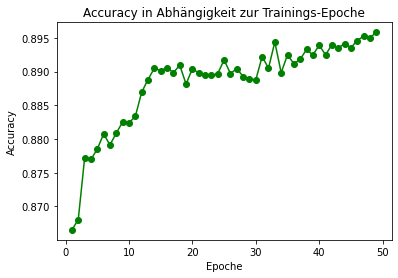

In [ ]:
import matplotlib.pyplot as plt

# number of employees of A
acc = [x[1] for x in train_results]
epochs = [x[0] for x in train_results]


# plot a line chart
plt.plot(epochs, acc, 'o-g')
# plt.plot(epochs, fidelity_inv_values, 'o-b')

# set axis titles
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
# set chart title
plt.title(f"Accuracy in Abhängigkeit zur Trainings-Epoche")
#plt.legend(['Fidelity+', 'Fidelity-'])
plt.show()

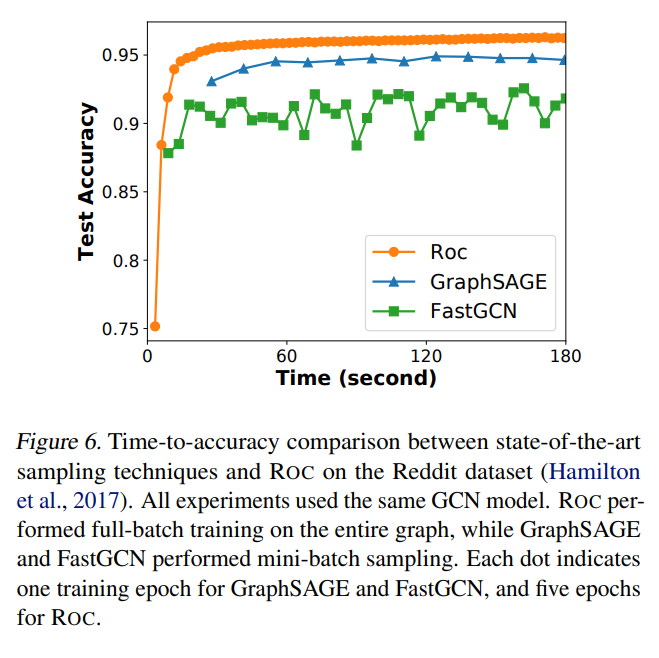

Quelle: Improving the Accuracy, Scalability, and Performance of Graph Neural Networks with ROC


Model speichern:

Speicherschema:
**model_encoder_datensatz_version**
- model: Verwendetes Model (gcn1, gcn2, gcn3)
- encoder: Verwendeter Encoder beim Preprocessing (ohe: OneHotEncoder, le: LabelEncoder)
- datensatz: Auf welchen Datensatz das Model trainiert wurde (review: Review-Datensatz, loan; Loan-Datensatz, baseline: Baseline-Datensatz
- feature: Anzahl der feauture (f1 -> 1 Feature)
- version: Wie vielte Version (Aufgrund von leichten Veränderungen im Preprocessing

In [ ]:
dataset_name

'loan_sn_f2_ohe_wEvents_4'

In [ ]:
# Save Model
torch.save(model.state_dict(), path / str("models/model1_" + dataset_name))

In [ ]:
dataset[0].edge_index

tensor([[0, 1, 1, 2, 3, 4, 5, 5, 6, 6, 7, 7, 8],
        [1, 1, 2, 3, 4, 5, 5, 6, 6, 7, 7, 8, 9]])

Beobachtung:

- Training viel schneller, wenn OneHotEncoding statt Label Encoding verwendet wird
- Bessere Accuracy bei OneHotEncoding (99,94%)